In [1]:
import numpy as np
from tqdm import tqdm
from geographiclib.geodesic import Geodesic

import torch
import warnings
import matplotlib.pyplot as plt

In [2]:
from readers.InSAR import InSAR
from readers.GNSS import GNSS

In [3]:
insar = InSAR('data/time_series_Saarland_Orbit139_update.nc')

Computing zscores and removing outliers for InSAR...


100%|██████████| 218637/218637 [01:02<00:00, 3495.90it/s]


In [4]:
selected_indices = np.load('data/InSAR_data/selected_insar_DILL.npy')
nn_dist = np.load('data/InSAR_data/nearest_neighbors_dist_DILL.npy')
nn_ind = np.load('data/InSAR_data/nearest_neighbors_ind_DILL.npy')

In [5]:
selected_indices.shape, nn_dist.shape, nn_ind.shape

((5000,), (5000, 1000), (5000, 1000))

In [6]:
selected_indices

array([162280, 162215, 162537, ..., 149707, 153490, 171113])

In [7]:
nn_dist

array([[  36.4300262 ,   45.82929417,   60.542051  , ..., 1376.78444606,
        1377.48755021, 1378.44401689],
       [  36.4300262 ,   57.55254083,   61.17344689, ..., 1390.14077067,
        1390.79450336, 1390.86473751],
       [  44.24780402,   45.82929417,   53.6518466 , ..., 1381.46111336,
        1381.99057403, 1382.45799641],
       ...,
       [   7.45355753,   33.36876137,   49.93085402, ..., 1046.58082827,
        1046.84244725, 1047.21265196],
       [  33.07101525,   47.79322469,   55.4900606 , ..., 1317.07720582,
        1318.32484561, 1318.89390909],
       [  71.47378249,   80.09273237,  125.98907739, ..., 2005.15916308,
        2005.55304142, 2005.65831503]])

In [8]:
nn_ind

array([[   1,    2,    3, ..., 1001,  998, 1005],
       [   0,    2,    4, ..., 1007,  985, 1049],
       [   3,    0,    5, ..., 1000,  968,  972],
       ...,
       [4977, 4900, 4834, ..., 3623, 2599, 2677],
       [4897, 4844, 4916, ..., 4146, 2201, 1569],
       [4787, 4917, 4723, ..., 1452, 1183, 2071]])

In [9]:
insar_df = insar.get_df() # TODO filter and all before
selected_insar = insar_df.loc[selected_indices]
selected_insar = selected_insar.reset_index(drop=True)

In [10]:
selected_insar

longitude   latitude  day_5809  day_5833  day_5857  day_5881  day_5905  \
0      6.699707  49.371651 -2.409891 -2.194344 -2.139533 -3.408697 -2.533108   
1      6.700134  49.371479 -0.549021  0.272253  4.025490  3.800844 -0.364619   
2      6.700056  49.371994 -1.861290 -0.830876 -0.193683 -0.965297 -3.009525   
3      6.699518  49.372181 -0.794152  0.344161 -0.803818 -0.791442  8.734901   
4      6.700358  49.370949 -1.501728 -0.563811  1.305797  2.617189  1.766856   
...         ...        ...       ...       ...       ...       ...       ...   
4995   6.736541  49.360138 -4.436625 -3.043354 -3.456805 -3.348606 -3.153361   
4996   6.732156  49.355431  0.458142 -2.815473  1.295940 -1.940554 -1.320045   
4997   6.727951  49.352348 -3.498746  0.269012  0.967864  0.247412  0.251706   
4998   6.733752  49.356899 -1.252293 -0.838132 -1.413145 -0.892593 -0.542070   
4999   6.677038  49.393753 -4.672356 -1.057009  3.670526  0.080281  2.304837   

      day_5929  day_5953  day_5977  ...  day_7249  day_7261  day_7273  \
0    -2.232647  2.847809 -3.311953  ... -0.512384 -4.897253 -3.311996   
1     2.158682  5.353925 -0.932772  ... -2.076890 -4.830012 -5.720918   
2    -1.261733  3.387521 -0.388672  ... -0.736267 -2.377818 -1.758735   
3    -2.292886 -3.550283 -3.029612  ... -2.577484 -4.563729  3.113022   
4     0.696129  6.805275  0.328182  ... -5.257840 -5.977939 -5.665263   
...        ...       ...       ...  ...       ...       ...       ...   
4995 -2.512869 -0.162834 -0.350637  ... -2.672105 -2.184941 -2.229232   
4996 -1.358075  1.151767 -0.329658  ... -1.176320 -2.239808  2.671559   
4997  2.820203 -0.339757  0.583860  ... -0.464390 -0.195718 -0.278304   
4998  0.446543 -0.062826 -0.283713  ...  0.025623  0.313753 -0.124637   
4999  7.466024  1.187617  1.920290  ... -3.074414 -1.721954 -2.774596   

      day_7285  day_7297  day_7309  day_7321  day_7333  day_7345  day_7357  
0     3.114402 -1.238399 -0.733019 -0.733647 -0.720585 -0.717989  0.525340  
1    -3.429445 -0.116862 -5.944150 -2.505507 -2.484776  3.901627  0.791945  
2    -0.456098 -0.604462  0.299383  0.937896  1.095932 -3.407665  0.740227  
3     4.315196 -0.478789 -7.475759 -3.214365 -5.046099 -1.034822  2.490348  
4     0.279412 -4.526405 -4.852218 -5.069303 -3.463333 -6.646893 -3.320553  
...        ...       ...       ...       ...       ...       ...       ...  
4995 -1.505903 -0.965923 -3.793946 -1.678290 -2.487032  0.239200 -2.962511  
4996 -1.822769 -1.707263 -0.535549  0.927029 -1.899011 -2.316554  3.231889  
4997  0.897950  1.383393 -0.477653  0.092904  0.969979  0.468888  1.297699  
4998  1.063218 -0.586638 -0.436060 -0.054395 -0.085689  1.912058  0.629218  
4999 -3.605494 -3.173758 -3.179165  0.236096 -2.934392 -3.664386 -1.227832  

[5000 rows x 114 columns]

In [11]:
k = 10
edges = []
edge_distances = []
for i in tqdm(range(selected_insar.shape[0])):
    selected_nodes = nn_ind[i, :k]
    for idx, j in enumerate(selected_nodes):
        # add edge in direction j->i
        edges.append([j,i])
        edge_distances.append(nn_dist[i,idx])

100%|██████████| 5000/5000 [00:00<00:00, 111137.42it/s]


In [12]:
edges = torch.tensor(edges, dtype=torch.long, device='cpu').t().contiguous()
edge_distances = torch.tensor(edge_distances, dtype=torch.float32, device='cpu').unsqueeze(1)

In [14]:
edges.shape, edge_distances.shape

(torch.Size([2, 50000]), torch.Size([50000, 1]))

In [17]:
InSAR.get_data_for_graph(selected_insar)

100%|██████████| 1548/1548 [00:11<00:00, 138.02it/s]


(tensor([[[-2.4099],
          [ 0.0000],
          [ 0.0000],
          ...,
          [ 0.0000],
          [ 0.0000],
          [ 0.5253]],
 
         [[-0.5490],
          [ 0.0000],
          [ 0.0000],
          ...,
          [ 0.0000],
          [ 0.0000],
          [ 0.7919]],
 
         [[-1.8613],
          [ 0.0000],
          [ 0.0000],
          ...,
          [ 0.0000],
          [ 0.0000],
          [ 0.7402]],
 
         ...,
 
         [[-3.4987],
          [ 0.0000],
          [ 0.0000],
          ...,
          [ 0.0000],
          [ 0.0000],
          [ 1.2977]],
 
         [[-1.2523],
          [ 0.0000],
          [ 0.0000],
          ...,
          [ 0.0000],
          [ 0.0000],
          [ 0.6292]],
 
         [[-4.6724],
          [ 0.0000],
          [ 0.0000],
          ...,
          [ 0.0000],
          [ 0.0000],
          [-1.2278]]]),
 tensor([[1., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.

In [172]:
master_day = insar.get_master_day()
gnss = GNSS('data/selected_stations_dates.csv', master_day)

site_gdf = gnss.get_sites_gdf()
site_lat = site_gdf["_latitude(deg)"]
site_long = site_gdf["_longitude(deg)"]

/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:92: UserWarning: BIWI does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:92: UserWarning: D525 does not have data for 6625. Using closest day 5920 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:92: UserWarning: LUX1 does not have data for 6625. Using closest day 6820 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:92: UserWarning: MOLV does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:92: UserWarning: MOUS does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:92: UserWarning: OBER does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:92: UserWarning: SI

In [40]:
site_gdf.iloc[0]

_longitude(deg)                                        5.939266
_latitude(deg)                                        49.567937
geometry           POINT (5.939266285018169 49.567937468627846)
Name: BAS4, dtype: object

In [34]:
site_gdf = site_gdf.to_crs("EPSG:32632") # https://epsg.io/32632

gnss_points = site_gdf.geometry.x


In [38]:
insar_gnss_dist = np.load('data/insar_gnss_distances.npy')

In [39]:
insar_gnss_dist.shape

(218637, 39)

In [41]:
insar_gnss_dist[:,0]

array([75885.51190375, 75932.62998792, 75902.98816829, ...,
       89360.83690048, 89303.53455479, 89086.67675658])

In [43]:
insar_df.iloc[0].latitude

49.001121520996094

In [46]:
Geodesic.WGS84.Inverse(insar_df.iloc[-1].latitude, insar_df.iloc[-1].longitude,
                       site_gdf.iloc[0]['_latitude(deg)'], site_gdf.iloc[0]['_longitude(deg)'])['s12']

89087.29163567878

In [51]:
long = insar.get_df().iloc[155296].longitude
lat = insar.get_df().iloc[155296].latitude

In [55]:
closest_test = insar.get_k_closest_points(long, lat, 1001)

Searching for 1001 nearest InSAR datapoints


100%|██████████| 218637/218637 [00:23<00:00, 9403.93it/s] 


In [53]:
nn_dist = np.load('data/InSAR_data/nearest_neighbors_dist.npy')
nn_ind = np.load('data/InSAR_data/nearest_neighbors_ind.npy')

In [63]:
closest_test.index.values[1:]

array([155081, 155400, 155181, 155615, 154860, 155613, 154855, 155080,
       154861, 154856, 155087, 156094, 155184, 154621, 156093, 155726,
       156223, 155404, 156092, 154623, 156087, 154738, 156095, 155608,
       156221, 156096, 154740, 155965, 156339, 155186, 155291, 155857,
       155300, 154873, 154179, 156578, 156575, 154866, 154397, 153951,
       156689, 156581, 156230, 154868, 153850, 156577, 154396, 153948,
       155089, 153950, 153847, 156682, 154059, 156576, 153744, 153743,
       156100, 156838, 153746, 153949, 157088, 153620, 156823, 155187,
       156231, 156099, 156584, 156466, 154516, 154184, 154297, 156844,
       154067, 154960, 154632, 157213, 156470, 156232, 154959, 155736,
       154958, 154876, 156973, 155303, 156842, 155740, 153957, 157477,
       156234, 154300, 153748, 153520, 155188, 155972, 157607, 153182,
       155622, 156699, 154290, 154747, 156237, 153075, 156458, 153077,
       153082, 157466, 155174, 157464, 157613, 155737, 156102, 154849,
      

In [65]:
nn_ind[155296] == closest_test.index.values[1:]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [71]:
np.max(np.abs(closest_test['distance(m)'].values[1:] - nn_dist[155296])) # not a lot of difference -> good

0.17972654724781023

# build graph

In [72]:
insar = InSAR('data/time_series_Saarland_Orbit139_update.nc')
master_day = insar.get_master_day()
gnss = GNSS('data/selected_stations_dates.csv', master_day)
insar_k = 10
nn_dist = np.load('data/InSAR_data/nearest_neighbors_dist.npy')
nn_ind = np.load('data/InSAR_data/nearest_neighbors_ind.npy')
gnss_insar_dist = np.load('data/insar_gnss_distances.npy')
dataset = 'derivative'
dtype = torch.float32
device = 'cpu'

Computing zscores and removing outliers for InSAR...


100%|██████████| 218637/218637 [01:02<00:00, 3521.77it/s]
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:92: UserWarning: BIWI does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:92: UserWarning: D525 does not have data for 6625. Using closest day 5920 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:92: UserWarning: LUX1 does not have data for 6625. Using closest day 6820 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:92: UserWarning: MOLV does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:92: UserWarning: MOUS does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:92: UserWarning: OBER does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/

In [74]:
insar_df = insar.get_df()

In [87]:
assert dataset in ['derivative', 'filtered', 'raw']
assert insar_df.shape[0] == nn_dist.shape[0]
assert insar_df.shape[0] == nn_ind.shape[0]
assert nn_ind.shape[1] == nn_dist.shape[1]
assert insar_k > 0
assert insar_k <= nn_ind.shape[1]
assert gnss_insar_dist.shape[0] == insar_df.shape[0]

In [89]:
n_gnss = gnss_insar_dist.shape[1]

In [91]:
n_insar = insar_df.shape[0]
edges = []
edge_distances = []
for i in tqdm(range(n_insar)):
    selected_nodes = nn_ind[i, :insar_k]
    for idx, j in enumerate(selected_nodes):
        # add edge in direction j->i
        edges.append([j,i])
        edge_distances.append(nn_dist[i,idx])
    for j in range(n_gnss):
        edges.append([n_insar+j, i])
        edge_distances.append(gnss_insar_dist[i, j])
        

100%|██████████| 218637/218637 [00:10<00:00, 20304.30it/s]


In [9]:
import utils

In [111]:
import importlib

In [138]:
importlib.reload(utils)

<module 'utils' from '/cluster/home/mfrancesc/DSLab/insar-super-resolution/utils.py'>

In [3]:
nn_dist = np.load('data/InSAR_data/nearest_neighbors_dist.npy')
nn_ind = np.load('data/InSAR_data/nearest_neighbors_ind.npy')
gnss_insar_dist = np.load('data/insar_gnss_distances.npy')

In [6]:
edge_index, edge_distances, num_nodes = utils.get_edges_and_distances(nn_ind, 
                                                                      nn_dist, 
                                                                      gnss_insar_dist, 
                                                                      10,
                                                                      gnss_to_insar_k = 1)

/cluster/home/mfrancesc/DSLab/insar-super-resolution/utils.py:43: UserWarning: Computing edges and edge distances for insar nodes, there are 218637 insar nodes and 39 gnss nodes
100%|██████████| 218637/218637 [00:04<00:00, 54342.99it/s]


In [114]:
edge_distances.shape

torch.Size([2405007, 1])

In [7]:
from tgnn4i.utils import compute_edge_weights

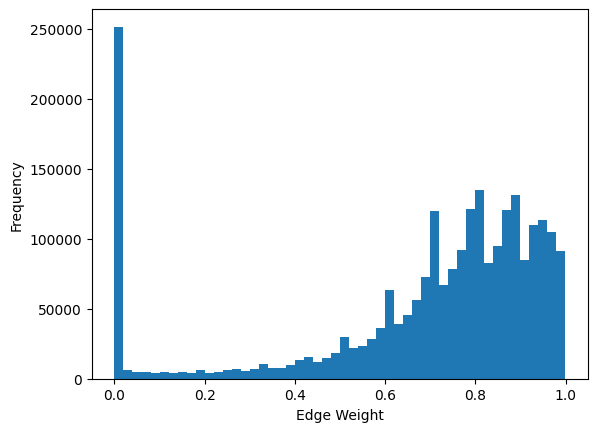

In [10]:
edge_weights = compute_edge_weights(edge_distances, 4, show_plot=True)

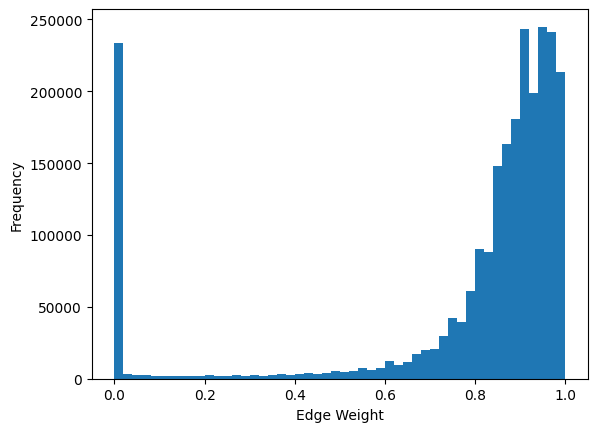

In [12]:
edge_weights = compute_edge_weights(edge_distances, 6, show_plot=True)

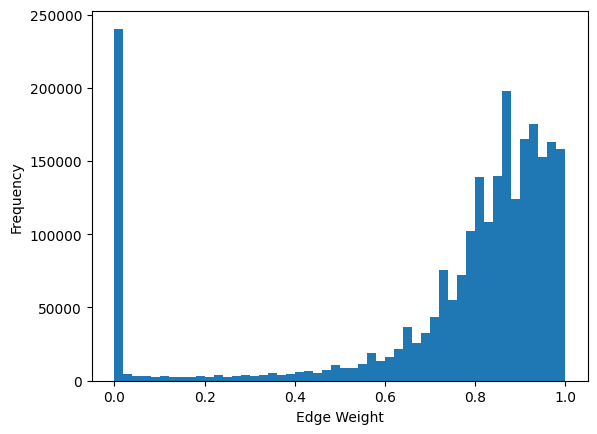

In [15]:
edge_weights = compute_edge_weights(edge_distances, 5, show_plot=True)

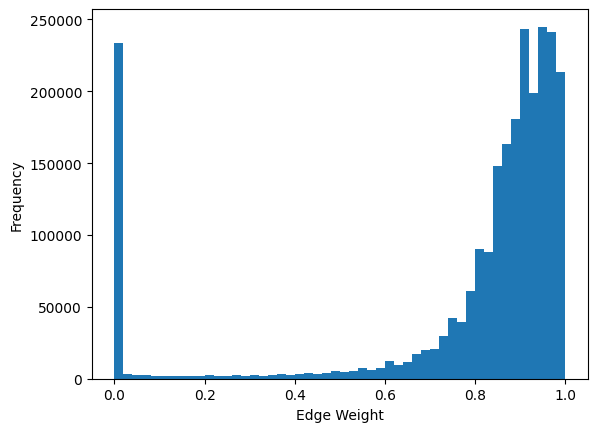

In [25]:
edge_weights = compute_edge_weights(edge_distances, 6, show_plot=True)

In [145]:
import torch_geometric as ptg

In [147]:
edges

[[2, 0],
 [5, 0],
 [1, 0],
 [10, 0],
 [8, 0],
 [15, 0],
 [11, 0],
 [6, 0],
 [14, 0],
 [9, 0],
 [218637, 0],
 [218638, 0],
 [218639, 0],
 [218640, 0],
 [218641, 0],
 [218642, 0],
 [218643, 0],
 [218644, 0],
 [218645, 0],
 [218646, 0],
 [218647, 0],
 [218648, 0],
 [218649, 0],
 [218650, 0],
 [218651, 0],
 [218652, 0],
 [218653, 0],
 [218654, 0],
 [218655, 0],
 [218656, 0],
 [218657, 0],
 [218658, 0],
 [218659, 0],
 [218660, 0],
 [218661, 0],
 [218662, 0],
 [218663, 0],
 [218664, 0],
 [218665, 0],
 [218666, 0],
 [218667, 0],
 [218668, 0],
 [218669, 0],
 [218670, 0],
 [218671, 0],
 [218672, 0],
 [218673, 0],
 [218674, 0],
 [218675, 0],
 [2, 1],
 [5, 1],
 [6, 1],
 [8, 1],
 [9, 1],
 [11, 1],
 [0, 1],
 [14, 1],
 [16, 1],
 [10, 1],
 [218637, 1],
 [218638, 1],
 [218639, 1],
 [218640, 1],
 [218641, 1],
 [218642, 1],
 [218643, 1],
 [218644, 1],
 [218645, 1],
 [218646, 1],
 [218647, 1],
 [218648, 1],
 [218649, 1],
 [218650, 1],
 [218651, 1],
 [218652, 1],
 [218653, 1],
 [218654, 1],
 [218655, 1],


In [151]:
graph = ptg.data.Data(edge_index=edge_index, edge_attr=edge_weights, num_nodes=num_nodes)

In [152]:
graph.is_directed()

True

In [159]:
edge_index, edge_weights, isolation_mask = ptg.utils.remove_isolated_nodes(edge_index,
        edge_weights, num_nodes=num_nodes)

In [165]:
(~isolation_mask).sum()

tensor(28)

In [170]:
np.unique(gnss_insar_dist.argmin(axis=1))

array([ 8,  9, 10, 11, 12, 13, 15, 17, 30, 32, 37])

In [177]:
gnss.filter_signal(insar.sampling_freq/5)
gnss.take_derivative()

site   day  st_up_derivative(mm)
0      BAS4  5809              0.000000
1      BAS4  5810             -0.021151
2      BAS4  5811             -0.015528
3      BAS4  5812             -0.009291
4      BAS4  5813             -0.002464
...     ...   ...                   ...
49412  WALF  7353              0.007797
49413  WALF  7354             -0.000047
49414  WALF  7355             -0.007364
49415  WALF  7356             -0.014112
49416  WALF  7357             -0.020254

[49169 rows x 3 columns]

In [4]:
import utils

In [5]:
insar = InSAR('data/time_series_Saarland_Orbit139_update.nc')
master_day = insar.get_master_day()
gnss = GNSS('data/selected_stations_dates.csv', master_day)

Computing zscores and removing outliers for InSAR...


100%|██████████| 218637/218637 [01:03<00:00, 3440.28it/s]
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: BIWI does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: D525 does not have data for 6625. Using closest day 5920 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: LUX1 does not have data for 6625. Using closest day 6820 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: MOLV does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: MOUS does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: OBER does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/

In [6]:
gnss.filter_signal(insar.sampling_freq/5)
insar.filter_signal(insar.sampling_freq/5)

Filtering InSAR signal...
Using raw dataset


100%|██████████| 218637/218637 [01:36<00:00, 2254.94it/s]


longitude   latitude  day_5809  day_5833  day_5857  day_5881  \
0        6.519765  49.001122  0.581905  0.786763  1.150152  1.251448   
1        6.520702  49.001022 -0.528713 -0.114022  0.546459  0.971507   
2        6.520345  49.001186 -4.311403 -4.351644 -4.261602 -3.533927   
3        6.522241  49.000980 -0.242642  0.050640  0.544588  0.921738   
4        6.522860  49.000912 -6.412433 -5.780645 -4.290851 -2.728341   
...           ...        ...       ...       ...       ...       ...   
218632   7.168369  49.499275 -1.919670 -1.571479 -1.403852 -1.738064   
218633   7.168715  49.499237 -0.082981 -0.484307 -0.153773  1.002933   
218634   7.169266  49.499302  0.279584  0.188659 -0.103649 -0.378606   
218635   7.168502  49.499516 -2.486160 -2.613852 -3.472874 -4.884002   
218636   7.165560  49.499973  1.731891  1.768743  2.269584  3.183012   

        day_5905  day_5929  day_5953  day_5977  ...  day_7249  day_7261  \
0       0.773824  0.008304 -0.373568 -0.123761  ...  0.174712 -0.658256   
1       0.801750  0.142768 -0.648110 -1.351831  ... -0.007150  0.191427   
2      -1.878324  0.093399  1.124784  0.595827  ...  0.636604 -0.498667   
3       1.014827  0.962676  0.895414  0.681168  ...  0.921925  1.203297   
4      -1.964740 -1.742243 -0.946970  0.726512  ... -1.685972 -1.615504   
...          ...       ...       ...       ...  ...       ...       ...   
218632 -2.331111 -2.591904 -2.286482 -1.820578  ...  2.857008  1.906369   
218633  1.957422  1.793165  0.856187  0.192978  ... -1.904903 -2.069089   
218634 -0.386085 -0.177144 -0.033966 -0.110938  ...  0.527795  0.496435   
218635 -5.774873 -5.264849 -3.821406 -2.838106  ...  0.121515  0.402295   
218636  4.081030  4.447253  3.925792  2.522047  ... -2.715769 -3.206756   

        day_7273  day_7285  day_7297  day_7309  day_7321  day_7333  day_7345  \
0      -1.553277 -2.132189 -2.231399 -2.034556 -1.814382 -1.675734 -1.585182   
1       1.019987  1.916919  2.139932  1.509912  0.550854 -0.101579 -0.286032   
2      -1.502091 -1.560756 -0.832342  0.003840  0.436097  0.411371  0.201823   
3       1.789529  2.394521  2.511185  2.091316  1.594305  1.431028  1.569705   
4      -2.342524 -2.631186 -1.717662 -0.162500  0.889709  0.995577  0.692048   
...          ...       ...       ...       ...       ...       ...       ...   
218632  0.985332  0.794528  1.182015  1.456527  1.229330  0.724465  0.361881   
218633 -1.625415 -0.832250 -0.136098  0.212547  0.310135  0.387492  0.524703   
218634  0.370856  0.258632  0.196000  0.195658  0.305559  0.524846  0.735312   
218635 -0.116762 -1.054309 -1.348802 -0.646714  0.281392  0.566613  0.219458   
218636 -3.803778 -4.207793 -4.184907 -3.716639 -3.131609 -2.891579 -3.123056   

        day_7357  
0      -1.518945  
1      -0.269012  
2       0.078658  
3       1.719253  
4       0.617093  
...          ...  
218632  0.279235  
218633  0.629529  
218634  0.817447  
218635 -0.134833  
218636 -3.493153  

[218637 rows x 114 columns]

In [7]:
gnss.take_derivative()
insar.take_derivative()

Taking derivative of InSAR signal...
Using filtered dataset


100%|██████████| 218637/218637 [00:11<00:00, 18464.50it/s]


longitude   latitude  day_5809  day_5833  day_5857  day_5881  \
0        6.519765  49.001122       0.0  0.008536  0.015141  0.004221   
1        6.520702  49.001022       0.0  0.017279  0.027520  0.017710   
2        6.520345  49.001186       0.0 -0.001677  0.003752  0.030320   
3        6.522241  49.000980       0.0  0.012220  0.020581  0.015715   
4        6.522860  49.000912       0.0  0.026324  0.062075  0.065105   
...           ...        ...       ...       ...       ...       ...   
218632   7.168369  49.499275       0.0  0.014508  0.006984 -0.013925   
218633   7.168715  49.499237       0.0 -0.016722  0.013772  0.048196   
218634   7.169266  49.499302       0.0 -0.003789 -0.012180 -0.011457   
218635   7.168502  49.499516       0.0 -0.005321 -0.035793 -0.058797   
218636   7.165560  49.499973       0.0  0.001535  0.020868  0.038059   

        day_5905  day_5929  day_5953  day_5977  ...  day_7249  day_7261  \
0      -0.019901 -0.031897 -0.015911  0.010409  ... -0.045904 -0.069414   
1      -0.007073 -0.027458 -0.032953 -0.029322  ... -0.028491  0.016548   
2       0.068983  0.082155  0.042974 -0.022040  ... -0.010088 -0.094606   
3       0.003879 -0.002173 -0.002803 -0.008927  ...  0.025010  0.023448   
4       0.031817  0.009271  0.033136  0.069728  ...  0.077554  0.005872   
...          ...       ...       ...       ...  ...       ...       ...   
218632 -0.024710 -0.010866  0.012726  0.019413  ... -0.014918 -0.079220   
218633  0.039770 -0.006844 -0.039041 -0.027634  ... -0.053705 -0.013682   
218634 -0.000312  0.008706  0.005966 -0.003207  ...  0.011186 -0.002613   
218635 -0.037120  0.021251  0.060143  0.040971  ...  0.029159  0.023398   
218636  0.037417  0.015259 -0.021728 -0.058489  ... -0.009162 -0.040916   

        day_7273  day_7285  day_7297  day_7309  day_7321  day_7333  day_7345  \
0      -0.074585 -0.048243 -0.008268  0.016404  0.018348  0.011554  0.007546   
1       0.069047  0.074744  0.018584 -0.052502 -0.079921 -0.054369 -0.015371   
2      -0.083619 -0.004889  0.060701  0.069682  0.036021 -0.002060 -0.017462   
3       0.048853  0.050416  0.009722 -0.034989 -0.041418 -0.013606  0.011556   
4      -0.060585 -0.024055  0.076127  0.129597  0.087684  0.008822 -0.025294   
...          ...       ...       ...       ...       ...       ...       ...   
218632 -0.076753 -0.015900  0.032291  0.022876 -0.018933 -0.042072 -0.030215   
218633  0.036973  0.066097  0.058013  0.029054  0.008132  0.006446  0.011434   
218634 -0.010465 -0.009352 -0.005219 -0.000028  0.009158  0.018274  0.017539   
218635 -0.043255 -0.078129 -0.024541  0.058507  0.077342  0.023768 -0.028930   
218636 -0.049752 -0.033668  0.001907  0.039022  0.048752  0.020003 -0.019290   

        day_7357  
0       0.005520  
1       0.001418  
2      -0.010264  
3       0.012462  
4      -0.006246  
...          ...  
218632 -0.006887  
218633  0.008735  
218634  0.006845  
218635 -0.029524  
218636 -0.030841  

[218637 rows x 114 columns]

In [6]:
insar = insar
gnss = gnss
dataset = 'derivative'
insar_k = 10
gnss_to_insar_k = 1
insar_nn_ind_path = 'data/InSAR_data/nearest_neighbors_ind.npy'
insar_nn_dist_path = 'data/InSAR_data/nearest_neighbors_dist.npy'
gnss_insar_dist_path = 'data/insar_gnss_distances.npy'
weight_scaling = 4
dtype=torch.float32
device='cpu'

In [7]:
insar_nn_ind = np.load(insar_nn_ind_path)
insar_nn_dist = np.load(insar_nn_dist_path)
gnss_insar_dist = np.load(gnss_insar_dist_path)
gnss_df = gnss.get_df()
if dataset == 'derivative':
    insar_df = insar.derivative_df
    gnss_df = gnss_df[['site', 'day', 'st_up_derivative(mm)']]
elif dataset == 'filtered':
    warnings.warn("Using filtered dataset, make sure this is what you want")
    insar_df = insar.filtered_df
    gnss_df = gnss_df[['site', 'day', 'st_up_filtered(mm)']]
elif dataset == 'raw':
    warnings.warn("Using raw dataset, make sure this is what you want")
    insar_df = insar.df
    gnss_df = gnss_df[['site', 'day', 'st_up_no_year(mm)']]
else:
    raise ValueError(f"Unknown dataset {dataset}")

if insar_df is None:
    raise ValueError(f"Dataset {dataset} is not available for InSAR")
gnss_df.columns = ['site', 'day', 'value']

assert insar_df.shape[0] == insar_nn_ind.shape[0]
assert insar_df.shape[0] == insar_nn_dist.shape[0]
assert insar_df.shape[0] == gnss_insar_dist.shape[0]

In [8]:
import utils

In [9]:
edges, edge_distances, num_nodes = utils.get_edges_and_distances(insar_nn_ind,
                                                             insar_nn_dist,
                                                             gnss_insar_dist,
                                                             insar_k,
                                                             gnss_to_insar_k = gnss_to_insar_k,
                                                             dtype=dtype,
                                                             device=device)

/cluster/home/mfrancesc/DSLab/insar-super-resolution/utils.py:42: UserWarning: Computing edges and edge distances for insar nodes, there are 218637 insar nodes and 39 gnss nodes
100%|██████████| 218637/218637 [00:03<00:00, 58328.80it/s]


In [10]:
from tgnn4i.utils import compute_edge_weights
edge_weights = compute_edge_weights(edge_distances, weight_scaling)
assert edges.shape[0] == 2
assert edge_weights.shape[0] == edges.shape[1]
assert edge_weights.shape[1] == 1

In [11]:
insar_y, insar_mask, insar_ts, insar_delta_ts, insar_first_day, insar_last_day = InSAR.get_data_for_graph(insar_df)

In [59]:
import importlib
import sys
importlib.reload(sys.modules['readers.GNSS'])

<module 'readers.GNSS' from '/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py'>

In [67]:
gnss_y, gnss_mask, gnss_ts, gnss_delta_ts = GNSS.get_data_for_graph(gnss_df, insar_first_day, insar_last_day)

100%|██████████| 39/39 [00:00<00:00, 214.17it/s]


In [61]:
insar_y.shape, insar_mask.shape, insar_ts.shape, insar_delta_ts.shape

(torch.Size([218637, 1549, 1]),
 torch.Size([218637, 1549]),
 torch.Size([1549]),
 torch.Size([218637, 1549]))

In [69]:
gnss_y.shape, gnss_mask.shape, gnss_ts.shape, gnss_delta_ts.shape

(torch.Size([39, 1549, 1]),
 torch.Size([39, 1549]),
 torch.Size([1549]),
 torch.Size([39, 1549]))

In [70]:
y = torch.cat([insar_y, gnss_y], dim=0)
mask = torch.cat([insar_mask, gnss_mask], dim=0)
delta_ts = torch.cat([insar_delta_ts, gnss_delta_ts], dim=0)

In [71]:
y.shape, mask.shape, delta_ts.shape

(torch.Size([218676, 1549, 1]),
 torch.Size([218676, 1549]),
 torch.Size([218676, 1549]))

In [74]:
assert (gnss_ts == insar_ts).all()

In [76]:
import torch_geometric as ptg

In [78]:
edge_index_rem, edge_weightsrem_, isolation_mask = ptg.utils.remove_isolated_nodes(edges,
        edge_weights, num_nodes=num_nodes)

In [81]:
edges.shape

torch.Size([2, 2405007])

In [90]:
edge_index_rem

tensor([[     2,      5,      1,  ..., 218621, 218601, 218641],
        [     0,      0,      0,  ..., 218636, 218636, 218636]])

In [91]:
edges

tensor([[     2,      5,      1,  ..., 218621, 218601, 218649],
        [     0,      0,      0,  ..., 218636, 218636, 218636]])

In [93]:
(edge_weightsrem_ == edge_weights).all()

tensor(True)

In [89]:
edge_index_rem != edges

tensor([[False, False, False,  ..., False, False,  True],
        [False, False, False,  ..., False, False, False]])

In [88]:
(~isolation_mask).nonzero()

tensor([[218637],
        [218638],
        [218639],
        [218640],
        [218641],
        [218642],
        [218643],
        [218644],
        [218651],
        [218653],
        [218655],
        [218656],
        [218657],
        [218658],
        [218659],
        [218660],
        [218661],
        [218662],
        [218663],
        [218664],
        [218665],
        [218666],
        [218668],
        [218670],
        [218671],
        [218672],
        [218673],
        [218675]])

# Final version

In [3]:
insar = insar
gnss = gnss
dataset = 'derivative'
insar_k = 10
gnss_to_insar_k = 1
insar_nn_ind_path = 'data/InSAR_data/nearest_neighbors_ind.npy'
insar_nn_dist_path = 'data/InSAR_data/nearest_neighbors_dist.npy'
gnss_insar_dist_path = 'data/insar_gnss_distances.npy'
weight_scaling = 4
dtype=torch.float16
device='cpu'

NameError: name 'insar' is not defined

In [9]:
graph = utils.build_graph(insar,
                gnss,
                dataset,
                insar_k,
                gnss_to_insar_k,
                insar_nn_ind_path,
                insar_nn_dist_path,
                gnss_insar_dist_path,
                weight_scaling,
                dtype=dtype,
                device=device
                )

/cluster/home/mfrancesc/DSLab/insar-super-resolution/utils.py:43: UserWarning: Computing edges and edge distances for insar nodes, there are 218637 insar nodes and 39 gnss nodes
100%|██████████| 218637/218637 [00:03<00:00, 55055.65it/s]
/cluster/home/mfrancesc/DSLab/insar-super-resolution/utils.py:121: UserWarning: Computing tensors for graph
100%|██████████| 39/39 [00:00<00:00, 237.49it/s]
/cluster/home/mfrancesc/DSLab/insar-super-resolution/utils.py:132: UserWarning: Removing isolated nodes
/cluster/home/mfrancesc/DSLab/insar-super-resolution/utils.py:137: UserWarning: Removed 28 isolated nodes


In [10]:
graph

Data(edge_index=[2, 2405007], edge_attr=[2405007, 1], y=[218648, 1549, 1], mask=[218648, 1549], t=[1, 1549], delta_t=[218648, 1549], hop_mask=[218648, 1549], update_delta_t=[218648, 1549], num_nodes=218648)

In [12]:
import argparse

import tgnn4i.constants as constants
import tgnn4i.pred_dists as pred_dists
from tgnn4i.gru_model import GRUModel
from tgnn4i.gru_node_model import GRUNodeModel
from tgnn4i.gru_graph_model import GRUGraphModel
from tgnn4i.transformer import TransformerForecaster
from tgnn4i.transformer_joint import TransformerJointForecaster
from tgnn4i.utils import parse_loss_weight


MODELS = {
    "grud_joint": GRUModel, # Ignore graph structure, evolve single joint latent state
    "grud_node": GRUNodeModel, # Treat each node independently, independent latent state
    "tgnn4i": GRUGraphModel, # Utilizes graph structure
    "transformer_node": TransformerForecaster,
    "transformer_joint": TransformerJointForecaster,
}

def get_config(args=None):
    parser = argparse.ArgumentParser(description='Train Models')
    # If config file should be used
    parser.add_argument("--config", type=str, help="Config file to read run config from")

    # General
    parser.add_argument("--model", type=str, default="tgnn4i",
            help="Which model to use")
    
    parser.add_argument("--insar-dataset", type=str, default='data/InSAR_data/time_series_Saarland_Orbit139_update.nc',
            help="Path to insar dataset")
    parser.add_argument("--gnss-dataset", type=str, default='data/selected_stations_dates.csv',
            help="Path to gnss dataset")
    parser.add_argument("--dataset-type", type=str, default='derivative',
            help="Type of dataset to use (derivative/filtered/raw)")
    parser.add_argument("--filter_scale", type=float, default=5.,
            help="Filter scale for derivative/filtered data")
    parser.add_argument("--insar_k", type=int, default=10,
            help="Number of nearest neighbors to use for insar nodes")
    parser.add_argument("--gnss_to_insar_k", type=int, default=1,
            help="Number of nearest neighbors to use for gnss nodes")
    parser.add_argument("--insar_nn_ind_path", type=str, default='data/InSAR_data/nearest_neighbors_ind.npy',
            help="Path to insar nearest neighbor indices")
    parser.add_argument("--insar_nn_dist_path", type=str, default='data/InSAR_data/nearest_neighbors_dist.npy',
            help="Path to insar nearest neighbor distances")
    parser.add_argument("--gnss_insar_dist_path", type=str, default='data/insar_gnss_distances.npy',
            help="Path to gnss insar distances")
    parser.add_argument("--edge_weight_scaling", type=float, default=6.,
            help="Scaling of edge weights")
    
    
    
    
    parser.add_argument("--seed", type=int, default=42,
            help="Seed for random number generator")
    parser.add_argument("--optimizer", type=str, default="adam",
            help="Optimizer to use for training")
    parser.add_argument("--test", type=int, default=0,
            help="Also evaluate on test set after training is done")
    parser.add_argument("--use_features", type=int, default=1,
            help="If additional input features should be used")
    parser.add_argument("--load", type=str,
            help="Load model parameters from path")

    # Model Architecture
    parser.add_argument("--gru_layers", type=int, default=1,
            help="Layers of GRU units")
    parser.add_argument("--decay_type", type=str, default="dynamic",
            help="Parametrization of GRU decay to use (none/to_const/dynamic)")
    parser.add_argument("--periodic", type=int, default=0,
            help="If latent state dynamics should include periodic component")
    parser.add_argument("--time_input", type=int, default=1,
            help="Concatenate time (delta_t) to the input at each timestep")
    parser.add_argument("--mask_input", type=int, default=1,
            help="Concatenate the observation mask as input")
    parser.add_argument("--hidden_dim", type=int, default=32,
            help="Dimensionality of hidden state in GRU units (latent node state))")
    parser.add_argument("--n_fc", type=int, default=2,
            help="Number of fully connected layers after GRU units")
    parser.add_argument("--pred_gnn", type=int, default=1,
            help="Number of GNN-layers to use in predictive part of model")
    parser.add_argument("--gru_gnn", type=int, default=1,
            help="Number of GNN layers used for GRU-cells")
    parser.add_argument("--gnn_type", type=str, default="graphconv",
            help="Type of GNN-layers to use")
    parser.add_argument("--node_params", type=int, default=0, # I think it should be 0 if each graph has different nodes
            help="Use node-specific parameters for initial state and decay target")
    parser.add_argument("--learn_init_state", type=int, default=0, # I think it should be 0 if each graph has different nodes
            help="If the initial state of GRU-units should be learned (otherwise 0)")

    # Training
    parser.add_argument("--epochs", type=int,
            help="How many epochs to train for", default=10)
    parser.add_argument("--val_interval", type=int, default=1,
            help="Evaluate model every val_interval:th epoch")
    parser.add_argument("--patience", type=int, default=20,
            help="How many evaluations to wait for improvement in val loss")
    parser.add_argument("--lr", type=float,
            help="Learning rate", default=1e-3)
    parser.add_argument("--l2_reg", type=float,
            help="L2-regularization coefficient", default=0.)
    parser.add_argument("--state_updates", type=str, default="obs",
            help="When the node state should be updated (all/obs/hop)")
    parser.add_argument("--loss_weighting", type=str, default="const",
            help="Function to weight loss with, given as: name,param1,...,paramK")
    parser.add_argument("--max_pred", type=int, default=10,
            help="Maximum number of time indices forward to predict")

    args = parser.parse_args(args) # TODO: Changes this when to .py file without argument to read input args
    config = vars(args)

    # Read additional config from file
    if args.config:
        assert os.path.exists(args.config), "No config file: {}".format(args.config)
        with open(args.config) as json_file:
            config_from_file = json.load(json_file)

        # Make sure all options in config file also exist in argparse config.
        # Avoids choosing wrong parameters because of typos etc.
        unknown_options = set(config_from_file.keys()).difference(set(config.keys()))
        unknown_error = "\n".join(["Unknown option in config file: {}".format(opt)
            for opt in unknown_options])
        assert (not unknown_options), unknown_error

        config.update(config_from_file)

    # Some asserts
    assert config["model"] in MODELS, f"Unknown model: {config['model']}"
    assert config["optimizer"] in constants.OPTIMIZERS, (
            f"Unknown optimizer: {config['optimizer']}")

    assert config["gnn_type"] in constants.GNN_LAYERS, (
            f"Unknown gnn_type: {config['gnn_type']}")
    assert (not bool(config["periodic"])) or (config["hidden_dim"] % 2 == 0), (
            "hidden_dim must be even when using periodic latent dynamics")

    return config

In [13]:
config=get_config('')
if torch.cuda.is_available():
    device = torch.device("cuda")

    # For reproducability on GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")

In [14]:
import torch_geometric as ptg

In [15]:
loader = ptg.loader.DataLoader([graph], batch_size=1, pin_memory=True)

In [16]:
loader.dataset

[Data(edge_index=[2, 2405007], edge_attr=[2405007, 1], y=[218648, 1549, 1], mask=[218648, 1549], t=[1, 1549], delta_t=[218648, 1549], hop_mask=[218648, 1549], update_delta_t=[218648, 1549], num_nodes=218648)]

In [18]:
config["num_nodes"] = loader.dataset[0].num_nodes
config["time_steps"] = loader.dataset[0].t.shape[1]
config["device"] = device
config["y_dim"] = loader.dataset[0].y.shape[-1]

config["has_features"] = hasattr(loader.dataset[0], "features") and\
    bool(config["use_features"]) # TODO: not done yet
if config["has_features"]:
    config["feature_dim"] = loader.dataset[0].features.shape[-1]
else:
    config["feature_dim"] = 0

config["param_dim"] = 1 #  to simplify we just predict the mean
loss_weight_func = parse_loss_weight(config["loss_weighting"])

In [19]:
model = MODELS[config["model"]](config)
model.half()
model.to(device)

In [23]:
opt = constants.OPTIMIZERS[config["optimizer"]](model.parameters(), lr=config["lr"],
            weight_decay=config["l2_reg"])

In [25]:
batch = next(iter(loader))
batch = batch.to(config["device"]) # Move all graphs to GPU

In [27]:
batch

DataBatch(edge_index=[2, 2405007], edge_attr=[2405007, 1], y=[218648, 1549, 1], mask=[218648, 1549], t=[1, 1549], delta_t=[218648, 1549], hop_mask=[218648, 1549], update_delta_t=[218648, 1549], num_nodes=218648, batch=[218648], ptr=[2])

In [28]:
full_pred_params, pred_delta_times = model.forward(
                batch) # (N_T, B*N, max_pred, d_y, d_param) and (N_T, B, max_pred)
print("Full pred params: ", full_pred_params.shape)
print("Pred delta times: ", pred_delta_times.shape)

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.79 GiB (GPU 0; 10.75 GiB total capacity; 6.39 GiB already allocated; 3.62 GiB free; 6.39 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [29]:
model.half()

GRUGraphModel(
  (gru_cells): ModuleList(
    (0): GRUGraphCell(
      (input_gnn): Sequential(
        (0) - GraphConv(3, 224): x, edge_index, edge_weight -> x
      )
      (state_gnn): Sequential(
        (0) - GraphConv(32, 224): x, edge_index, edge_weight -> x
      )
    )
  )
  (post_gru_layers): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (pred_gnn_model): Sequential(
    (0) - GraphConv(33, 32): x, edge_index, edge_weight -> x
  )
)

In [30]:
torch.cuda.memory_reserved(0), torch.cuda.memory_allocated(0)

(6866075648, 6861365248)

In [57]:
torch.cuda.empty_cache()


In [55]:
ptg.profile.get_data_size(graph) / 2**20

3921.82861328125

In [51]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 0.074MB
